In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from pathlib import Path
from typing import List

In [2]:
data_folder = Path("../test_results")

## Index logs

In [3]:
index_logs_path = lambda db: Path(data_folder, f"index_logs_{db}_10000000_100.pickle")

In [4]:
def load_data(path: Path) -> dict:
    with open(path, 'rb') as datafile:
        data = pickle.load(datafile)
    return data

In [5]:
es_index_logs = pd.DataFrame(
    load_data(index_logs_path("elasticsearch"))["performance_results"]
)
batch_size = es_index_logs["data_size"][0]
es_index_logs["cumulative_size"] = np.cumsum(es_index_logs["data_size"])
es_index_logs["cumulative_time"] = np.cumsum(es_index_logs["time_spent"])

In [6]:
es_index_logs.head()

,data_size,time_spent,cumulative_size,cumulative_time
0,10000,11.915910,10000,11.915910
1,10000,8.363455,20000,20.279366
2,10000,8.362814,30000,28.642180
3,10000,8.340496,40000,36.982676
4,10000,9.366858,50000,46.349533


In [7]:
pg_index_logs = pd.DataFrame(
    load_data(index_logs_path("postgres"))["performance_results"]
)
pg_index_logs["cumulative_size"] = np.cumsum(pg_index_logs["data_size"])
pg_index_logs["cumulative_time"] = np.cumsum(pg_index_logs["time_spent"])

In [8]:
sns.set_theme()

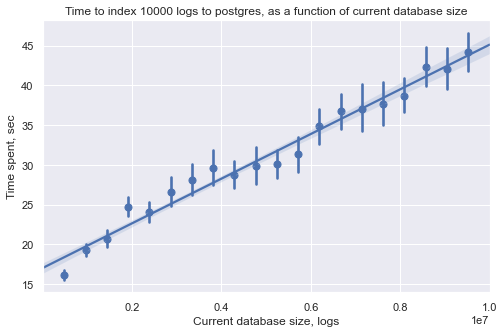

In [9]:
plt.figure(figsize=(8, 5))
plt.title(
    f"Time to index {batch_size} logs to postgres, as a function of current database size"
)
sns.regplot(x="cumulative_size", y="time_spent", data=pg_index_logs, x_bins=20)
plt.xlabel("Current database size, logs")
plt.ylabel("Time spent, sec")
plt.show()

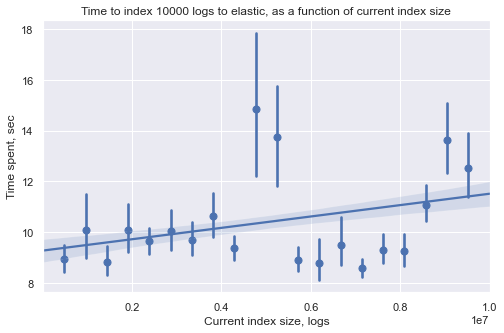

In [10]:
plt.figure(figsize=(8, 5))
plt.title(
    f"Time to index {batch_size} logs to elastic, as a function of current index size"
)
sns.regplot(x="cumulative_size", y="time_spent", data=es_index_logs, x_bins=20)
plt.xlabel("Current index size, logs")
plt.ylabel("Time spent, sec")
plt.show()

In [11]:
es_index_logs["database"] = "elastic"
pg_index_logs["database"] = "postgres"
index_logs_df = pd.concat([es_index_logs, pg_index_logs], ignore_index=True)

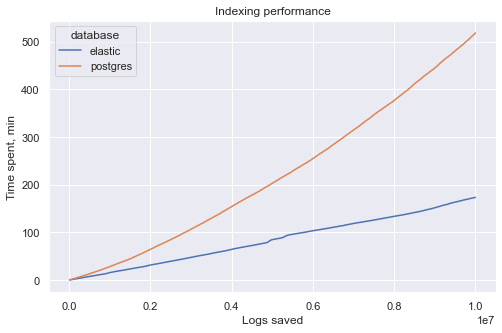

In [12]:
plt.figure(figsize=(8, 5))
plt.title("Indexing performance")
sns.lineplot(
    x="cumulative_size",
    y=index_logs_df["cumulative_time"] / 60,
    hue="database",
    data=index_logs_df,
)
plt.xlabel("Logs saved")
plt.ylabel("Time spent, min")
plt.show()

## Get logs by ids

In [13]:
get_logs_path = lambda db: Path(data_folder, f"get_logs_by_ids_{db}_10000000_100.pickle")

In [14]:
def unfold_results(results: List[dict]) -> List[dict]:
    undolded_results = []
    for result in results:
        undolded_results += [
            {"ids_size": result["ids_size"], "time_spent": time_value}
            for time_value in result["time_spent"]
        ]
    return undolded_results

In [15]:
es_get_logs = pd.DataFrame(
    unfold_results(load_data(get_logs_path("elasticsearch"))["performance_results"])
)
pg_get_logs = pd.DataFrame(
    unfold_results(load_data(get_logs_path("postgres"))["performance_results"])
)
es_get_logs["database"] = "elastic"
pg_get_logs["database"] = "postgres"
get_logs_df = pd.concat([es_get_logs, pg_get_logs], ignore_index=True)

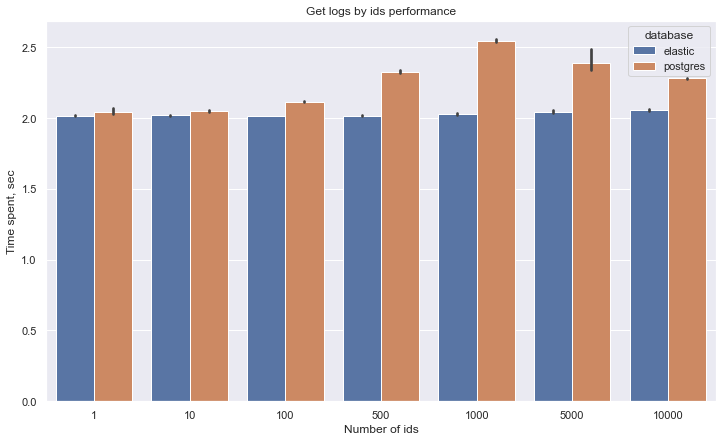

In [16]:
plt.figure(figsize=(12, 7))
plt.title("Get logs by ids performance")
sns.barplot(x="ids_size", y=get_logs_df["time_spent"], hue="database", data=get_logs_df)
plt.xlabel("Number of ids")
plt.ylabel("Time spent, sec")
plt.show()

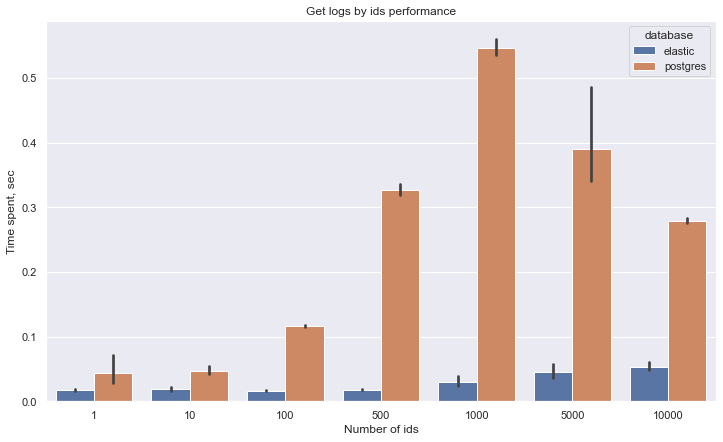

In [17]:
plt.figure(figsize=(12, 7))
plt.title("Get logs by ids performance")
sns.barplot(x="ids_size", y=get_logs_df["time_spent"] - 2, hue="database", data=get_logs_df)
plt.xlabel("Number of ids")
plt.ylabel("Time spent, sec")
plt.show()

In [18]:
get_logs_df.groupby(["ids_size", "database"]).mean() - 2

time_spent
ids_size database            
1        elastic     0.017081
         postgres    0.043448
10       elastic     0.018846
         postgres    0.046854
100      elastic     0.016325
         postgres    0.116207
500      elastic     0.017609
         postgres    0.326791
1000     elastic     0.030485
         postgres    0.546036
5000     elastic     0.045044
         postgres    0.390876
10000    elastic     0.053797
         postgres    0.279380

## Get logs by id cache

In [19]:
def unfold_results_cache(results: List[dict]) -> List[dict]:
    unfolded_results = []
    for result in results:
        ids_size = result["ids_size"]
        for idx in range(len(result["time_spent"])):
            time_spent = result["time_spent"][idx]
            cached_values = result["time_spent_cache"][idx]
            unfolded_results += [
                {"ids_size": ids_size, "time_spent": time_spent, "repetition": 0}
            ]
            for repetition in range(len(cached_values)):
                unfolded_results += [
                    {
                        "ids_size": ids_size,
                        "time_spent": cached_values[repetition],
                        "repetition": repetition + 1,
                    }
                ]
    return unfolded_results

In [20]:
pg_get_logs_cache = pd.DataFrame(
    unfold_results_cache(load_data(get_logs_path("postgres"))["performance_results"])
)

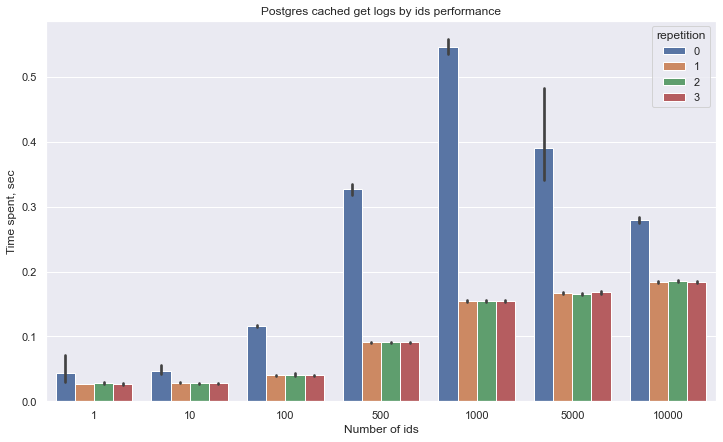

In [21]:
plt.figure(figsize=(12, 7))
plt.title("Postgres cached get logs by ids performance")
sns.barplot(x="ids_size", 
            y=pg_get_logs_cache["time_spent"] - 2, 
            hue="repetition", 
            data=pg_get_logs_cache)
plt.xlabel("Number of ids")
plt.ylabel("Time spent, sec")
plt.show()

In [22]:
es_get_logs_cache = pd.DataFrame(
    unfold_results_cache(load_data(get_logs_path("elasticsearch"))["performance_results"])
)

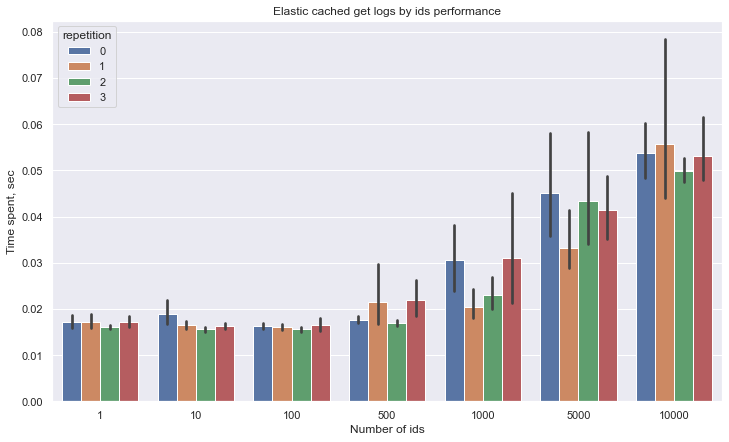

In [23]:
plt.figure(figsize=(12, 7))
plt.title("Elastic cached get logs by ids performance")
sns.barplot(x="ids_size", 
            y=es_get_logs_cache["time_spent"] - 2, 
            hue="repetition", 
            data=es_get_logs_cache)
plt.xlabel("Number of ids")
plt.ylabel("Time spent, sec")
plt.show()

## Search logs

In [24]:
search_logs_path = lambda db: Path(data_folder, f"search_logs_{db}_10000000_100.pickle")

In [25]:
es_search_logs = pd.DataFrame(
    load_data(search_logs_path("elasticsearch"))["performance_results"]
)
es_search_logs["database"] = "elastic"
pg_search_logs = pd.DataFrame(
    load_data(search_logs_path("postgres"))["performance_results"]
)
pg_search_logs["database"] = "postgres"
search_logs_df = pd.concat([es_search_logs, pg_search_logs], ignore_index=True)


In [26]:
print(f"Error types: {search_logs_df.error.unique()}")
search_logs_df = search_logs_df[search_logs_df["error"] == "OK"]

Error types: ['OK']


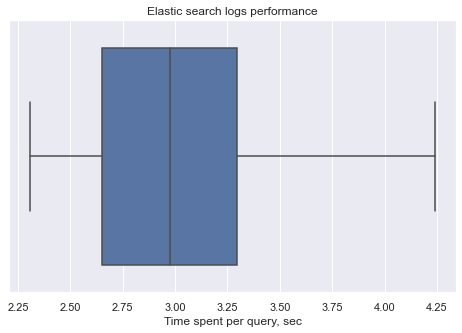

In [27]:
plt.figure(figsize=(8, 5))
plt.title("Elastic search logs performance")
sns.boxplot(
    x="time_spent", data=search_logs_df[search_logs_df["database"] == "elastic"]
)
plt.xlabel("Time spent per query, sec")
plt.show()

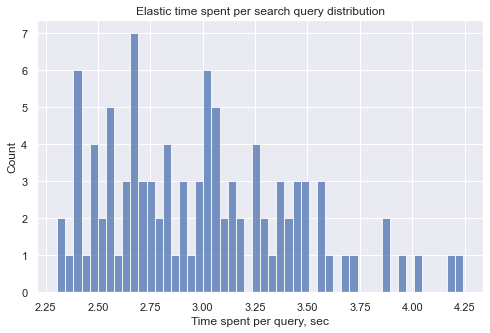

In [28]:
plt.figure(figsize=(8, 5))
plt.title("Elastic time spent per search query distribution")
sns.histplot(
    x="time_spent",
    data=search_logs_df[search_logs_df["database"] == "elastic"],
    bins=50,
)
plt.xlabel("Time spent per query, sec")
plt.show()

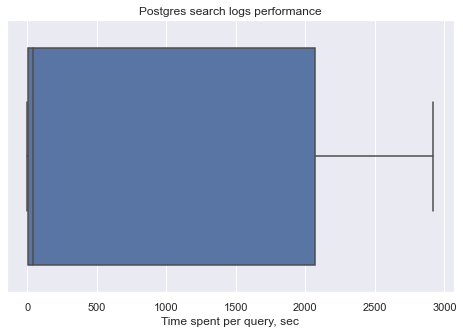

In [29]:
plt.figure(figsize=(8, 5))
plt.title("Postgres search logs performance")
sns.boxplot(
    x="time_spent", data=search_logs_df[search_logs_df["database"] == "postgres"]
)
plt.xlabel("Time spent per query, sec")
plt.show()

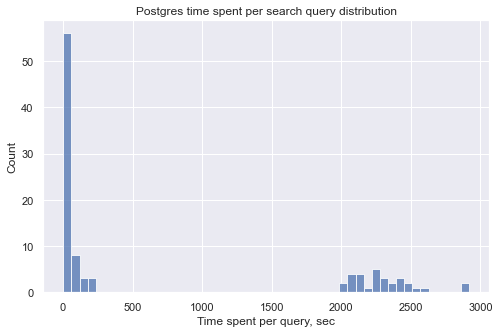

In [30]:
plt.figure(figsize=(8, 5))
plt.title("Postgres time spent per search query distribution")
sns.histplot(
    x="time_spent",
    data=search_logs_df[search_logs_df["database"] == "postgres"],
    bins=50,
)
plt.xlabel("Time spent per query, sec")
plt.show()

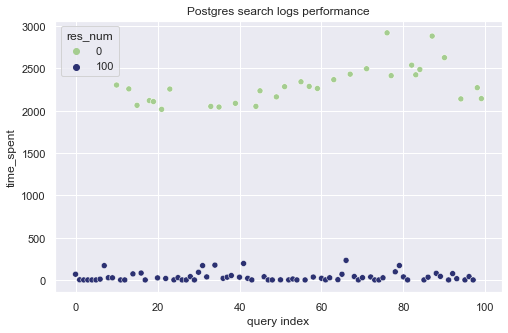

In [31]:
plt.figure(figsize=(8, 5))
plt.title("Postgres search logs performance")
sns.scatterplot(
    x=range(100),
    y="time_spent",
    hue="res_num",
    palette="crest",
    data=search_logs_df[search_logs_df["database"] == "postgres"],
)
plt.xlabel("query index")
plt.show()

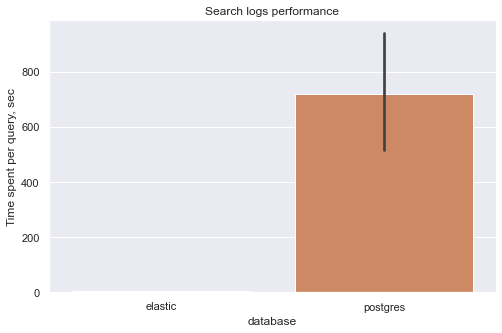

In [32]:
plt.figure(figsize=(8, 5))
plt.title("Search logs performance")
sns.barplot(x="database", y="time_spent", data=search_logs_df)
plt.ylabel("Time spent per query, sec")
plt.show()

In [33]:
es_search_time = search_logs_df[search_logs_df["database"] == "elastic"]["time_spent"]
pg_search_time = search_logs_df[search_logs_df["database"] == "postgres"]["time_spent"]
pg_with_result = search_logs_df[
    (search_logs_df["database"] == "postgres") & (search_logs_df["res_num"] != 0)
]["time_spent"]
pg_no_result = search_logs_df[
    (search_logs_df["database"] == "postgres") & (search_logs_df["res_num"] == 0)
]["time_spent"]
search_time_df = pd.DataFrame(
    {
        "elastic": es_search_time,
        "postgres": pg_search_time,
        "pg_with_result": pg_with_result,
        "pg_no_result": pg_no_result,
    }
)
search_time_df.describe()


,elastic,postgres,pg_with_result,pg_no_result
count,100.000000,100.000000,70.000000,30.000000
mean,2.994456,717.995207,38.722654,2302.964495
std,0.447379,1051.139778,52.773697,229.677872
min,2.305832,2.592069,2.592069,2017.211625
25%,2.653374,3.310308,2.734746,2125.086771
50%,2.977182,39.432333,21.993844,2267.950560
75%,3.293406,2070.264326,42.065321,2422.001407
max,4.242572,2920.042397,233.673969,2920.042397


## Search logs by pattern

In [34]:
search_logs_by_pattern_path = lambda db: Path(data_folder, f"search_logs_by_pattern_{db}_10000000_100.pickle")

In [35]:
es_search_logs_by_pattern = pd.DataFrame(
    load_data(search_logs_by_pattern_path("elasticsearch"))["performance_results"]
)
es_search_logs_by_pattern["database"] = "elastic"
pg_search_logs_by_pattern = pd.DataFrame(
    load_data(search_logs_by_pattern_path("postgres"))["performance_results"]
)
pg_search_logs_by_pattern["database"] = "postgres"
search_logs_by_pattern_df = pd.concat(
    [
        es_search_logs_by_pattern[es_search_logs_by_pattern["error"] == "OK"],
        pg_search_logs_by_pattern[pg_search_logs_by_pattern["error"] == "OK"],
    ],
    ignore_index=True,
)

In [36]:
es_search_logs_by_pattern[es_search_logs_by_pattern["error"] != "OK"]

,query,time_spent,res_num,error,database


In [37]:
pg_search_logs_by_pattern[pg_search_logs_by_pattern["error"] != "OK"]

,query,time_spent,res_num,error,database
9,org\.openqa\.selenium\.TimeoutException: Ex.* ...,2.032245,0,INTERNAL SERVER ERROR,postgres
32,java\.lang\.AssertionError: O.* 'WBC' informat...,2.027670,0,INTERNAL SERVER ERROR,postgres
36,java\.lang\.RuntimeException: Option with text...,2.026090,0,INTERNAL SERVER ERROR,postgres
44,or.* Expe.* con.* failed: waiting for t.* 'Ldt.*,2.028140,0,INTERNAL SERVER ERROR,postgres
51,java\.lang\.AssertionError: Th.* i.* no.* pat....,2.027160,0,INTERNAL SERVER ERROR,postgres
67,java\.lang\.RuntimeException: Option wi.* text...,2.027956,0,INTERNAL SERVER ERROR,postgres
70,org\.openqa\.selenium\.TimeoutException: Expec...,2.017862,0,INTERNAL SERVER ERROR,postgres
99,org\.openqa\.selenium\.TimeoutException: Expec...,2.025498,0,INTERNAL SERVER ERROR,postgres


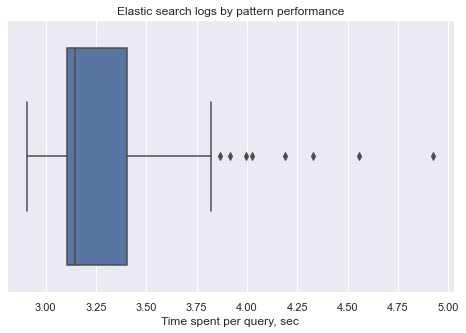

In [38]:
plt.figure(figsize=(8, 5))
plt.title("Elastic search logs by pattern performance")
sns.boxplot(
    x="time_spent",
    data=search_logs_by_pattern_df[search_logs_by_pattern_df["database"] == "elastic"],
)
plt.xlabel("Time spent per query, sec")
plt.show()

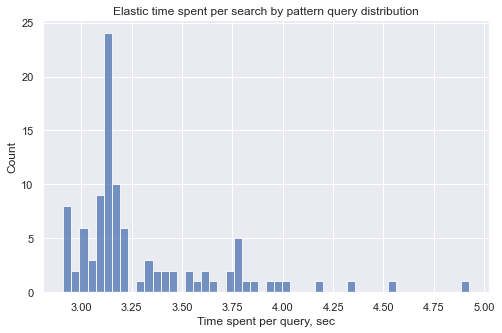

In [39]:
plt.figure(figsize=(8, 5))
plt.title("Elastic time spent per search by pattern query distribution")
sns.histplot(
    x="time_spent",
    data=search_logs_by_pattern_df[search_logs_by_pattern_df["database"] == "elastic"],
    bins=50,
)
plt.xlabel("Time spent per query, sec")
plt.show()

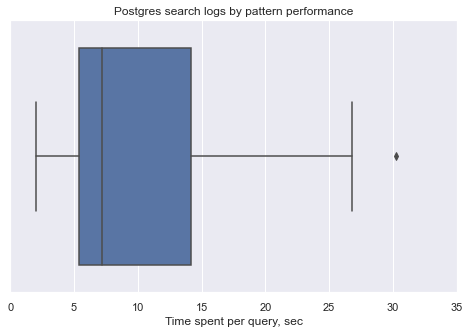

In [40]:
plt.figure(figsize=(8, 5))
plt.title("Postgres search logs by pattern performance")
sns.boxplot(
    x="time_spent",
    data=search_logs_by_pattern_df[search_logs_by_pattern_df["database"] == "postgres"],
)
plt.xlabel("Time spent per query, sec")
plt.xlim(0, 35)
plt.show()

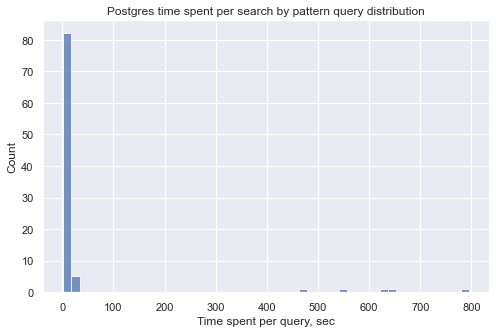

In [41]:
plt.figure(figsize=(8, 5))
plt.title("Postgres time spent per search by pattern query distribution")
sns.histplot(
    x="time_spent",
    data=search_logs_by_pattern_df[search_logs_by_pattern_df["database"] == "postgres"],
    bins=50,
)
plt.xlabel("Time spent per query, sec")
plt.show()

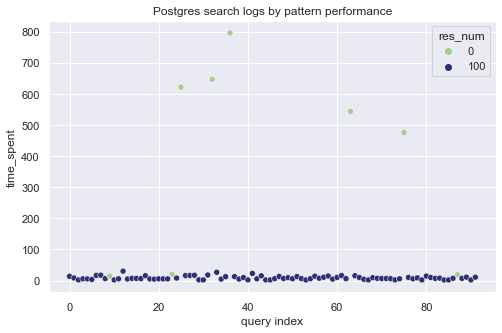

In [42]:
plt.figure(figsize=(8, 5))
plt.title("Postgres search logs by pattern performance")
sns.scatterplot(
    x=range(92),
    y="time_spent",
    hue="res_num",
    palette="crest",
    data=search_logs_by_pattern_df[search_logs_by_pattern_df["database"] == "postgres"],
)
plt.xlabel("query index")
plt.show()

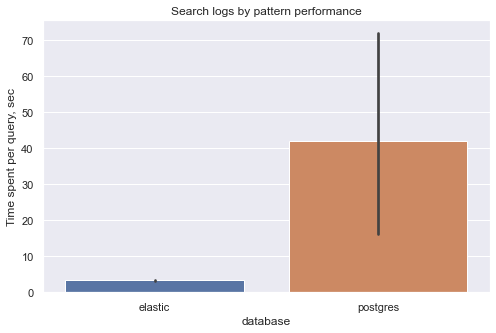

In [43]:
plt.figure(figsize=(8, 5))
plt.title("Search logs by pattern performance")
sns.barplot(x="database", y="time_spent", data=search_logs_by_pattern_df)
plt.ylabel("Time spent per query, sec")
plt.show()

In [44]:
es_search_time = search_logs_by_pattern_df[
    search_logs_by_pattern_df["database"] == "elastic"
]["time_spent"]
pg_search_time = search_logs_by_pattern_df[
    search_logs_by_pattern_df["database"] == "postgres"
]["time_spent"]
pg_with_result = search_logs_by_pattern_df[
    (search_logs_by_pattern_df["database"] == "postgres")
    & (search_logs_by_pattern_df["res_num"] != 0)
]["time_spent"]
pg_no_result = search_logs_by_pattern_df[
    (search_logs_by_pattern_df["database"] == "postgres")
    & (search_logs_by_pattern_df["res_num"] == 0)
]["time_spent"]
search_by_pattern_time_df = pd.DataFrame(
    {
        "elastic": es_search_time,
        "postgres": pg_search_time,
        "pg_with_result": pg_with_result,
        "pg_no_result": pg_no_result,
    }
)
search_by_pattern_time_df.describe()

,elastic,postgres,pg_with_result,pg_no_result
count,100.000000,92.000000,84.000000,8.000000
mean,3.297473,41.978203,8.627075,392.165041
std,0.369513,140.951239,5.731849,323.090752
min,2.910426,2.047573,2.047573,14.123242
25%,3.107229,5.401649,5.252102,20.154555
50%,3.144299,7.187053,6.916576,509.691028
75%,3.403680,14.156994,11.456182,627.930351
max,4.924972,795.862279,30.266069,795.862279


## Delete logs

In [45]:
delete_logs_path = lambda db: Path(data_folder, f"delete_logs_{db}_10000000_100.pickle")

In [46]:
es_delete_logs = pd.DataFrame(
    unfold_results(load_data(delete_logs_path("elasticsearch"))["performance_results"])
)
pg_delete_logs = pd.DataFrame(
    unfold_results(load_data(delete_logs_path("postgres"))["performance_results"])
)
es_delete_logs["database"] = "elastic"
pg_delete_logs["database"] = "postgres"
delete_logs_df = pd.concat([es_delete_logs, pg_delete_logs], ignore_index=True)

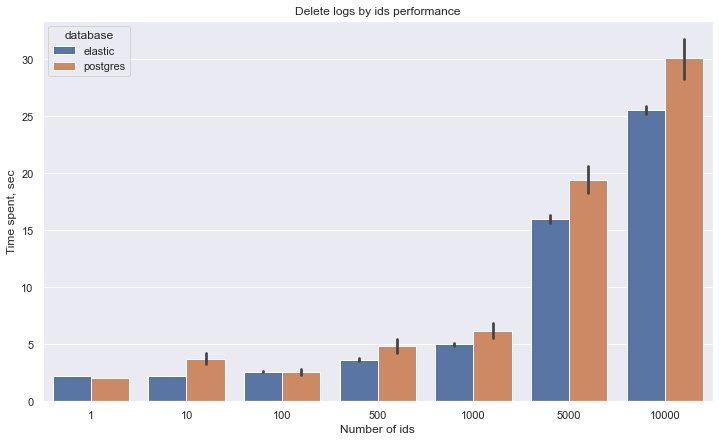

In [47]:
plt.figure(figsize=(12, 7))
plt.title("Delete logs by ids performance")
sns.barplot(x="ids_size", y="time_spent", hue="database", data=delete_logs_df)
plt.xlabel("Number of ids")
plt.ylabel("Time spent, sec")
plt.show()

In [48]:
delete_logs_df["time_spent"].min()

2.016510009765625

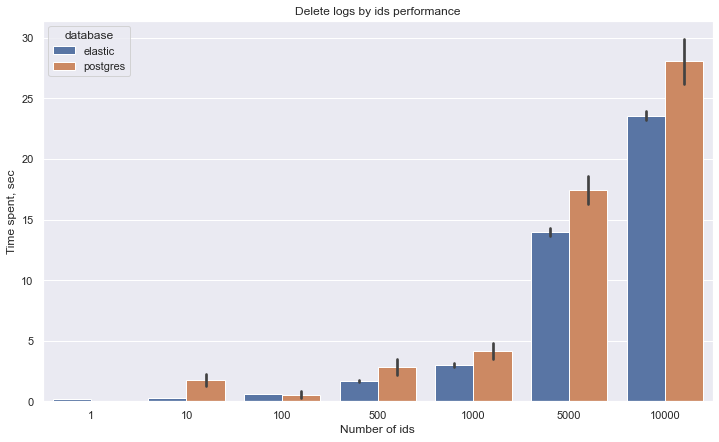

In [49]:
plt.figure(figsize=(12, 7))
plt.title("Delete logs by ids performance")
sns.barplot(x="ids_size", y=delete_logs_df["time_spent"] - 2, hue="database", data=delete_logs_df)
plt.xlabel("Number of ids")
plt.ylabel("Time spent, sec")
plt.show()

## Delete logs by date

In [50]:
delete_logs_by_date_path = lambda db: Path(data_folder, f"delete_logs_by_date_{db}_10000000_100.pickle")

In [51]:
es_delete_logs_by_date = pd.DataFrame({
    "time_spent": load_data(delete_logs_by_date_path("elasticsearch"))["performance_results"],
    "database": "elastic"
})
# pg_delete_logs_by_date = pd.DataFrame({
#     "time_spent": load_data(delete_logs_by_date_path("postgres"))["performance_results"],
#     "database": "postgres"
# })
# delete_logs_by_date_df = pd.concat([es_delete_logs_by_date, pg_delete_logs_by_date], ignore_index=True)
delete_logs_by_date_df = es_delete_logs_by_date

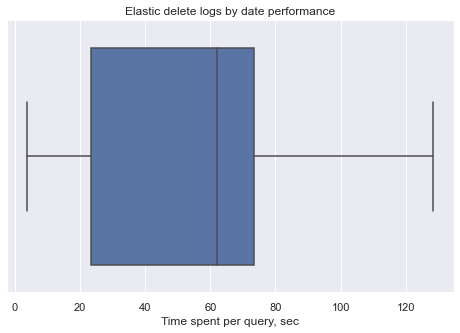

In [52]:
plt.figure(figsize=(8, 5))
plt.title("Elastic delete logs by date performance")
sns.boxplot(
    x="time_spent",
    data=delete_logs_by_date_df[delete_logs_by_date_df["database"] == "elastic"],
)
plt.xlabel("Time spent per query, sec")
plt.show()

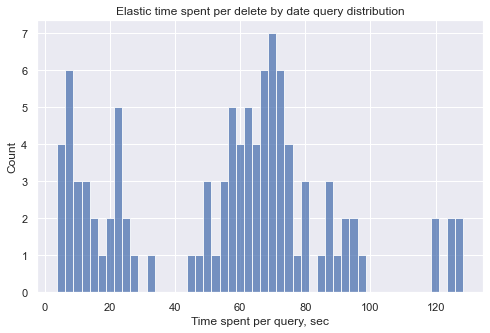

In [53]:
plt.figure(figsize=(8, 5))
plt.title("Elastic time spent per delete by date query distribution")
sns.histplot(
    x="time_spent",
    data=delete_logs_by_date_df[delete_logs_by_date_df["database"] == "elastic"],
    bins=50,
)
plt.xlabel("Time spent per query, sec")
plt.show()